In [31]:
# -*- coding: utf-8 -*-

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
#K.set_image_dim_ordering('th')

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

import pandas as pd
import csv
from os.path import splitext
import os.path

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

PATH = os.getcwd()
img_rows=128
img_cols=128
num_channel=1
num_epoch=20
styleFilePath = os.path.abspath('./style_filter.csv')
print(styleFilePath)
styledf=pd.read_csv(styleFilePath)
styledf = styledf.head(2000)

C:\Users\rohit\Downloads\style_filter.csv


In [43]:
top_words = 5000
X_train, X_test, y_train, y_test = train_test_split(styledf['productDisplayName'], styledf['articleType'], test_size=0.5, random_state=2)

In [44]:
import re
import nltk
nltk.download('stopwords')
df = styledf.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['productDisplayName'] = df['productDisplayName'].apply(clean_text)
df['productDisplayName'] = df['productDisplayName'].str.replace('\d+', '')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['productDisplayName'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1039 unique tokens.


In [46]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['productDisplayName'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2000, 250)


# Converting categorical labels to numbers.

In [47]:
Y = pd.get_dummies(df['articleType']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2000, 3)


# Train test split.

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.5, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1000, 250) (1000, 3)
(1000, 250) (1000, 3)


In [50]:

from keras.callbacks import EarlyStopping  
from keras.layers.core import Dense, SpatialDropout1D
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 15s 17ms/step - loss: 0.9285 - acc: 0.6944 - val_loss: 0.7231 - val_acc: 0.7100
Epoch 2/5
900/900 [==============================] - 8s 9ms/step - loss: 0.6833 - acc: 0.7311 - val_loss: 0.6008 - val_acc: 0.7100
Epoch 3/5
900/900 [==============================] - 9s 10ms/step - loss: 0.5502 - acc: 0.7400 - val_loss: 0.4390 - val_acc: 0.7500
Epoch 4/5
900/900 [==============================] - 8s 9ms/step - loss: 0.3557 - acc: 0.8656 - val_loss: 0.2404 - val_acc: 0.9400
Epoch 5/5
900/900 [==============================] - 9s 10ms/step - loss: 0.1975 - acc: 0.9256 - val_loss: 0.1365 - val_acc: 0.9600


5
(1000,)
(1000,)


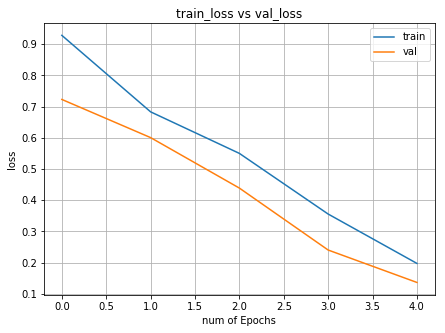

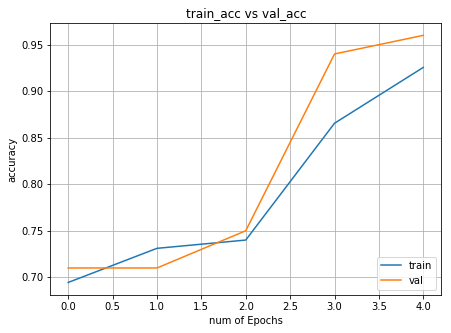

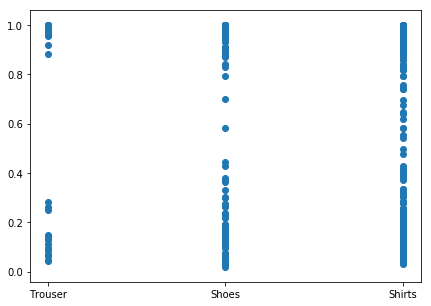

In [62]:
# visualizing losses and accuracy
hist = history
train_loss=history.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(5)
print(len(train_loss))
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic']

predictions = model.predict(X_test)
print(y_test.shape)
print(predictions[:,0].shape)
plt.figure(3,figsize=(7,5))
#plt.scatter(y_test,predictions[:,0])